# Supervised Machine Learning


We are going to predict:
- Number of people attacking
- Weapon
- If the attack is going to be extended more than 24h


In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [2]:
gt = pd.read_csv('CSVs/globalterrorism.csv')
display(gt.shape)
gt.head()

(43793, 19)

,iyear,imonth,iday,more_than_24h,country_txt,city,latitude,longitude,news,suicide,attacktype,attacktype_txt,targtype,targtype_txt,band_name,npeople_attacking,weapon,weapon_txt,nkill
0,1970,3,5,0,United States,San Juan,18.386932,-66.061127,3/5/1970: Unknown Puerto Rican Nationalists as...,0,1,Assassination,4,Military,Other,1,5,Firearms,2
1,1970,3,9,0,United States,Bel Air,39.538940,-76.348479,3/9/1970: A bomb exploded in the car of Ralph ...,0,3,Bombing/Explosion,20,Unknown,Other,2,6,Explosives,2
2,1970,3,20,0,United States,Detroit,42.331685,-83.047924,3/20/1970: Unknown perpetrators shot and kille...,0,1,Assassination,14,Private Citizens & Property,Other,7,5,Firearms,1
3,1970,4,24,0,United States,Baltimore,39.308342,-76.616104,4/24/1970: Three members of the Black Panthers...,0,2,Armed Assault,3,Police,Other,3,5,Firearms,1
4,1970,5,9,0,United States,Sacramento,38.551295,-121.471066,5/9/1970: Sacramento Police Officer Bernard Be...,0,2,Armed Assault,3,Police,Other,40,5,Firearms,1


### One Hot Encoding

In [3]:
gts = gt[['iyear', 'more_than_24h', 'country_txt', 'npeople_attacking', 'suicide', 'attacktype_txt', 'targtype_txt', 'band_name', 'weapon_txt', 'nkill']].copy()
gts.dtypes

iyear                 int64
more_than_24h         int64
country_txt          object
npeople_attacking     int64
suicide               int64
attacktype_txt       object
targtype_txt         object
band_name            object
weapon_txt           object
nkill                 int64
dtype: object

In [4]:
gts = pd.get_dummies(gts, drop_first=True)
display(gts.shape)
display(gts.head())
print(gts.dtypes)

(43793, 104)

,iyear,more_than_24h,npeople_attacking,suicide,nkill,country_txt_Algeria,country_txt_Bangladesh,country_txt_Burundi,country_txt_Cameroon,country_txt_Colombia,...,weapon_txt_Explosives,weapon_txt_Fake Weapons,weapon_txt_Firearms,weapon_txt_Incendiary,weapon_txt_Melee,weapon_txt_Other,weapon_txt_Radiological,weapon_txt_Sabotage Equipment,weapon_txt_Unknown,weapon_txt_Vehicle (not explosive)
0,1970,0,1,0,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1970,0,2,0,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1970,0,7,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1970,0,3,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1970,0,40,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


iyear                                                         int64
more_than_24h                                                 int64
npeople_attacking                                             int64
suicide                                                       int64
nkill                                                         int64
country_txt_Algeria                                           uint8
country_txt_Bangladesh                                        uint8
country_txt_Burundi                                           uint8
country_txt_Cameroon                                          uint8
country_txt_Colombia                                          uint8
country_txt_Democratic Republic of the Congo                  uint8
country_txt_Egypt                                             uint8
country_txt_India                                             uint8
country_txt_Indonesia                                         uint8
country_txt_Iraq                                

## Modeling, Prediction, and Evaluation

### 1-. Predict Number of people attacking

##### Bins Number of People (Multiclass)

In [5]:
bins = [0, 1, 3, 6, 10, 20, 30, 40]

gts['people_binned'] = pd.cut(gts['npeople_attacking'], bins = bins)
gts.drop(['npeople_attacking'], axis = 1, inplace = True)
display(gts.head())

,iyear,more_than_24h,suicide,nkill,country_txt_Algeria,country_txt_Bangladesh,country_txt_Burundi,country_txt_Cameroon,country_txt_Colombia,country_txt_Democratic Republic of the Congo,...,weapon_txt_Fake Weapons,weapon_txt_Firearms,weapon_txt_Incendiary,weapon_txt_Melee,weapon_txt_Other,weapon_txt_Radiological,weapon_txt_Sabotage Equipment,weapon_txt_Unknown,weapon_txt_Vehicle (not explosive),people_binned
0,1970,0,0,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"(0, 1]"
1,1970,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"(1, 3]"
2,1970,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"(6, 10]"
3,1970,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"(1, 3]"
4,1970,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"(30, 40]"


In [6]:
gts.people_binned.value_counts()

(1, 3]      7995
(20, 30]    7854
(3, 6]      7849
(10, 20]    6469
(0, 1]      6437
(6, 10]     4925
(30, 40]    1516
Name: people_binned, dtype: int64

#### One Hot Encoding variable y

In [7]:
y = gts[['people_binned']].copy()
X = gts.drop(['people_binned'], axis = 1)

display(X.head(), X.shape, y.head(), y.shape)

,iyear,more_than_24h,suicide,nkill,country_txt_Algeria,country_txt_Bangladesh,country_txt_Burundi,country_txt_Cameroon,country_txt_Colombia,country_txt_Democratic Republic of the Congo,...,weapon_txt_Explosives,weapon_txt_Fake Weapons,weapon_txt_Firearms,weapon_txt_Incendiary,weapon_txt_Melee,weapon_txt_Other,weapon_txt_Radiological,weapon_txt_Sabotage Equipment,weapon_txt_Unknown,weapon_txt_Vehicle (not explosive)
0,1970,0,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1970,0,0,2,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1970,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1970,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1970,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


(43793, 103)

,people_binned
0,"(0, 1]"
1,"(1, 3]"
2,"(6, 10]"
3,"(1, 3]"
4,"(30, 40]"


(43793, 1)

In [8]:
y = pd.get_dummies(y, drop_first=True)
y.head()

,"people_binned_(1, 3]","people_binned_(3, 6]","people_binned_(6, 10]","people_binned_(10, 20]","people_binned_(20, 30]","people_binned_(30, 40]"
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,1


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) # no se pone random_state para que sea randomly generated sin saltos
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35034, 103) (8759, 103) (35034, 6) (8759, 6)


#### SVC

with OnevsRestClassifier because it's multiclass

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.svm import SVC

clf = OneVsRestClassifier(svm.SVC())
scores1 = cross_val_score(clf, X, y, cv=5)
print(scores1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.21908894 0.15138714 0.13688777 0.09374286 0.21237726]
Accuracy: 0.16 (+/- 0.09)


#### RandomForestClassifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

clsrf = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))
scores2 = cross_val_score(clsrf, X, y, cv=5)
print(scores2)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

[0.21874643 0.20047951 0.14522206 0.24172185 0.32598767]
Accuracy: 0.23 (+/- 0.12)


#### KNeighborsClassifier

In [13]:
from sklearn.neighbors import KNeighborsClassifier

clsk = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
scores3 = cross_val_score(clsk, X, y, cv=5)
print(scores3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

[0.17992922 0.19557027 0.14408037 0.29687143 0.26410139]
Accuracy: 0.22 (+/- 0.11)


#### LinearRegression

In [14]:
from sklearn import linear_model

clsl = OneVsRestClassifier(linear_model.LinearRegression())
scores4 = cross_val_score(clsl, X, y, cv=5)
print(scores4)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))

[0.09670054 0.15150131 0.1367736  0.09454213 0.20255766]
Accuracy: 0.14 (+/- 0.08)


#### Logistic Regression (solver="lbfgs")

In [11]:
from sklearn.linear_model import LogisticRegression

clslr = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
scores5 = cross_val_score(clslr, X, y, cv=5)
print(scores5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores5.mean(), scores5.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[0.23187578 0.15104464 0.13745861 0.09374286 0.21329071]
Accuracy: 0.17 (+/- 0.10)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


###  Fit Train & Test with SVC, Random Forest, KNN, Linear Regression & Logistic Regression

In [15]:
# SVC (without probability=True)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

0.1637173193286905

In [16]:
# Random Forest Classifier

clsrf.fit(X_train, y_train)
clsrf.score(X_test, y_test)

0.3826920881379153

In [17]:
# KNeighborsClassifier

clsk.fit(X_train, y_train)
clsk.score(X_test, y_test)

0.3797237127525973

In [18]:
# Linear Regression

clsl.fit(X_train, y_train)
clsl.score(X_test, y_test)

0.17285078205274576

## Model SVC (probability = True)

#### y_pred Accuracy

In [21]:
# Prediction accuracy SVC

from sklearn import metrics
'''
clfc = OneVsRestClassifier(svm.SVC(probability = True))
clfc.fit(X_train, y_train)
y_pred2 = clfc.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
'''

clfc = OneVsRestClassifier(svm.SVC(probability = True))
y_score = clfc.fit(X_train, y_train).predict_proba(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

#### Precision, Recall & F-score

In [22]:
actual_values = y_test.values.argmax(axis=1)
predictions = clfc.predict(X_test).argmax(axis=1)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
precision = pd.DataFrame(precision_score(actual_values, predictions, average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions, average=None))
f_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
precision_recall = pd.concat([precision, recall, f_score], axis=1)
precision_recall.columns = ['Precision', 'Recall', 'F score']
precision_recall.index = ['people_binned_(1, 3]', 'people_binned_(3, 6]', 'people_binned_(6, 10]', 'people_binned_(10, 20]', 'people_binned_(20, 30]', 'people_binned_(30, 40]']
precision_recall.index.name = 'Number of People Attacking'
precision_recall

,Precision,Recall,F score
Number of People Attacking,,,
"people_binned_(1, 3]",0.350845,1.000000,0.519445
"people_binned_(3, 6]",1.000000,0.000638,0.001276
"people_binned_(6, 10]",0.000000,0.000000,0.000000
"people_binned_(10, 20]",0.000000,0.000000,0.000000
"people_binned_(20, 30]",0.000000,0.000000,0.000000
"people_binned_(30, 40]",0.000000,0.000000,0.000000


#### Accuracy Score (Balanced and not Balanced)

In [25]:
# NO PONDERADO
# Ratio correct vs incorrect predictions

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.3508391368877726

In [26]:
# PONDERADO ---> Más real
# Ratio correct vs incorrect predictions

balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.16677302701552862

#### Confusion Matrix

Confusion matrix, without normalization
[[3072    0    0    0    0    0]
 [1565    1    0    1    0    0]
 [ 973    0    0    0    0    0]
 [1325    0    0    0    0    0]
 [1525    0    0    1    0    0]
 [ 296    0    0    0    0    0]]


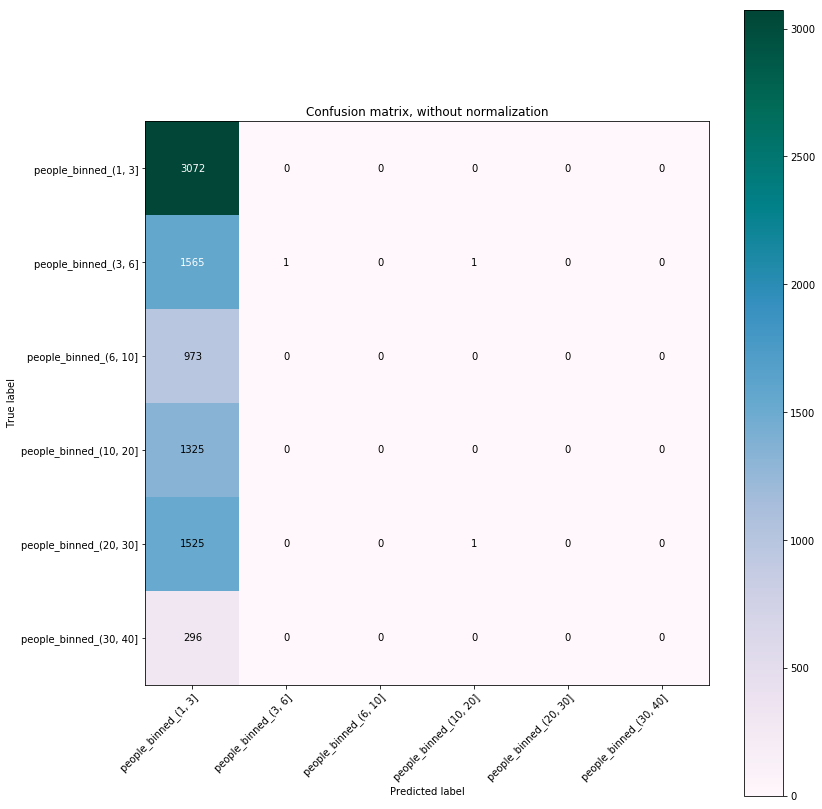

In [27]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.PuBuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

#### Roc Curve 

In [29]:
# binarizar la variable y

from sklearn.preprocessing import label_binarize

y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [30]:
# SVC (Probability = True)

clfc = OneVsRestClassifier(svm.SVC(probability = True))
y_score = clfc.fit(X_train, y_train).predict_proba(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [31]:
# Roc Curve 
# Auc

from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [32]:
# micro-average Roc curve 
# micro-average Auc

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [33]:
# macro-average Roc curve 
# macro-average Auc

from scipy import interp

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

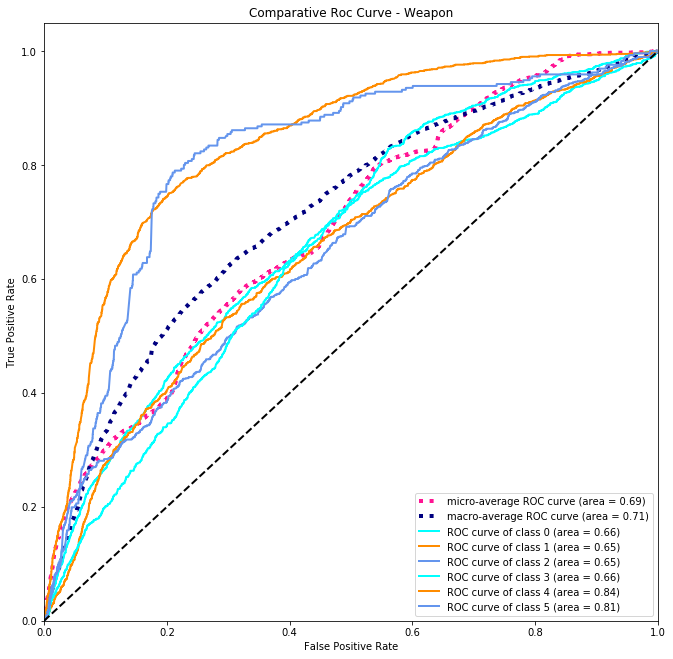

In [34]:
from itertools import cycle

plt.figure(figsize = (11, 11))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative Roc Curve - Weapon')
plt.legend(loc="lower right")
plt.show()

### 2-. Predict Weapon

In [7]:
y = gts[['weapon_txt_Explosives', 'weapon_txt_Fake Weapons', 'weapon_txt_Firearms', 'weapon_txt_Incendiary', 'weapon_txt_Melee', 'weapon_txt_Other', 'weapon_txt_Radiological', 'weapon_txt_Sabotage Equipment', 'weapon_txt_Unknown', 'weapon_txt_Vehicle (not explosive)']].copy()
X = gts.drop(['weapon_txt_Explosives', 'weapon_txt_Fake Weapons', 'weapon_txt_Firearms', 'weapon_txt_Incendiary', 'weapon_txt_Melee', 'weapon_txt_Other', 'weapon_txt_Radiological', 'weapon_txt_Sabotage Equipment', 'weapon_txt_Unknown', 'weapon_txt_Vehicle (not explosive)'], axis = 1)

display(X.head(), X.shape, y.head(), y.shape)

,iyear,more_than_24h,npeople_attacking,suicide,nkill,country_txt_Algeria,country_txt_Bangladesh,country_txt_Cameroon,country_txt_Colombia,country_txt_Democratic Republic of the Congo,...,nationality_txt_Somalia,nationality_txt_Spain,nationality_txt_Sri Lanka,nationality_txt_Sudan,nationality_txt_Syria,nationality_txt_Thailand,nationality_txt_Turkey,nationality_txt_Ukraine,nationality_txt_United States,nationality_txt_Yemen
0,1970,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1970,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1970,0,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1970,0,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1970,0,2,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


(47759, 94)

,weapon_txt_Explosives,weapon_txt_Fake Weapons,weapon_txt_Firearms,weapon_txt_Incendiary,weapon_txt_Melee,weapon_txt_Other,weapon_txt_Radiological,weapon_txt_Sabotage Equipment,weapon_txt_Unknown,weapon_txt_Vehicle (not explosive)
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


(47759, 10)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) # no se pone random_state para que sea randomly generated sin saltos
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(38207, 94) (9552, 94) (38207, 10) (9552, 10)


#### SVC

##### with OnevsRestClassifier because it's multiclass

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.svm import SVC

In [12]:
clfc = OneVsRestClassifier(svm.SVC())
scores4 = cross_val_score(clfc, X, y, cv=5)
print(scores4)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

[0.48544807 0.90923367 0.92724037 0.88400335 0.8836771 ]
Accuracy: 0.82 (+/- 0.33)


#### RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

clsr = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))
scores5 = cross_val_score(clsr, X, y, cv=5)
print(scores5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores5.mean(), scores5.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))


[0.84390704 0.89991625 0.91289782 0.8845268  0.88849335]
Accuracy: 0.89 (+/- 0.05)


#### KNeighborsClassifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier

clsk = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
scores6 = cross_val_score(clsk, X, y, cv=5)
print(scores6)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores6.mean(), scores6.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))


[0.68069514 0.76570352 0.80307789 0.74989531 0.73981782]
Accuracy: 0.75 (+/- 0.08)


#### LinearRegression 

In [13]:
from sklearn import linear_model

clsl = OneVsRestClassifier(linear_model.LinearRegression())
scores7 = cross_val_score(clsl, X, y, cv=5)
print(scores7)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores7.mean(), scores7.std() * 2))

[0.09670054 0.15150131 0.1367736  0.09454213 0.20255766]
Accuracy: 0.14 (+/- 0.08)


#### Logistic Regression (solver="lbfgs")

In [14]:
from sklearn.linear_model import LogisticRegression

clslr = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
scores8 = cross_val_score(clslr, X, y, cv=5)
print(scores8)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores8.mean(), scores8.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[0.23187578 0.15104464 0.13745861 0.09374286 0.21329071]
Accuracy: 0.17 (+/- 0.10)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Fit Train & Test with SVC, Random Forest Classifier, KNN, Linear Regression & Logistic Regression

In [22]:
# SVC

clfc.fit(X_train, y_train)
clfc.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

0.8960427135678392

In [18]:
# Random Forest Classifier

clsr.fit(X_train, y_train)
clsr.score(X_test, y_test)

0.8990787269681743

In [19]:
# K-Near Neighbors

clsk.fit(X_train, y_train)
clsk.score(X_test, y_test)

0.804857621440536

In [20]:
# Linear Regression

clsl.fit(X_train, y_train)
clsl.score(X_test, y_test)

0.9089195979899497

In [21]:
# Logistic Regression (solver="lbfgs")

clslr.fit(X_train, y_train)
clslr.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

0.907035175879397

### Model Linear Regression

#### y_pred Accuracy

In [23]:
# Prediction accuracy Linear Regression

from sklearn import metrics

y_pred1 = clsl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred1))

Accuracy: 0.9089195979899497


### Precision vs Recall & F-score

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [25]:
actual_values = y_test.values.argmax(axis=1)
predictions = clsl.predict(X_test).argmax(axis=1)

In [26]:
precision = pd.DataFrame(precision_score(actual_values, predictions, average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions, average=None))
f_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
precision_recall = pd.concat([precision, recall, f_score], axis=1)
precision_recall.columns = ['Precision', 'Recall', 'F score']
precision_recall.index = ['weapon_txt_Explosives', 'weapon_txt_Fake Weapons', 'weapon_txt_Firearms', 'weapon_txt_Incendiary', 'weapon_txt_Melee', 'weapon_txt_Radiological', 'weapon_txt_Sabotage Equipment']
precision_recall.index.name = 'Weapon'
precision_recall

,Precision,Recall,F score
Weapon,,,
weapon_txt_Explosives,0.980728,0.917512,0.948067
weapon_txt_Fake Weapons,0.847248,0.987219,0.911893
weapon_txt_Firearms,0.640000,0.516129,0.571429
weapon_txt_Incendiary,0.000000,0.000000,0.000000
weapon_txt_Melee,0.000000,0.000000,0.000000
weapon_txt_Radiological,1.000000,0.726804,0.841791
weapon_txt_Sabotage Equipment,1.000000,0.083333,0.153846


#### Accuracy Score (Balanced and not balanced)

In [31]:
from sklearn.metrics import accuracy_score

# NO PONDERADO
# Ratio correct vs incorrect predictions

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9105946398659966

In [32]:
from sklearn.metrics import balanced_accuracy_score

# PONDERADO ---> Más real
# Ratio correct vs incorrect predictions

balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.4615710366475879

#### Confusion Matrix

Confusion matrix, without normalization
[[4071  366    0    0    0    0    0]
 [  44 4171   10    0    0    0    0]
 [   1   29   32    0    0    0    0]
 [  19  213    0    0    0    0    0]
 [   1    1    0    0    0    0    0]
 [  13  138    8    0    0  423    0]
 [   2    5    0    4    0    0    1]]


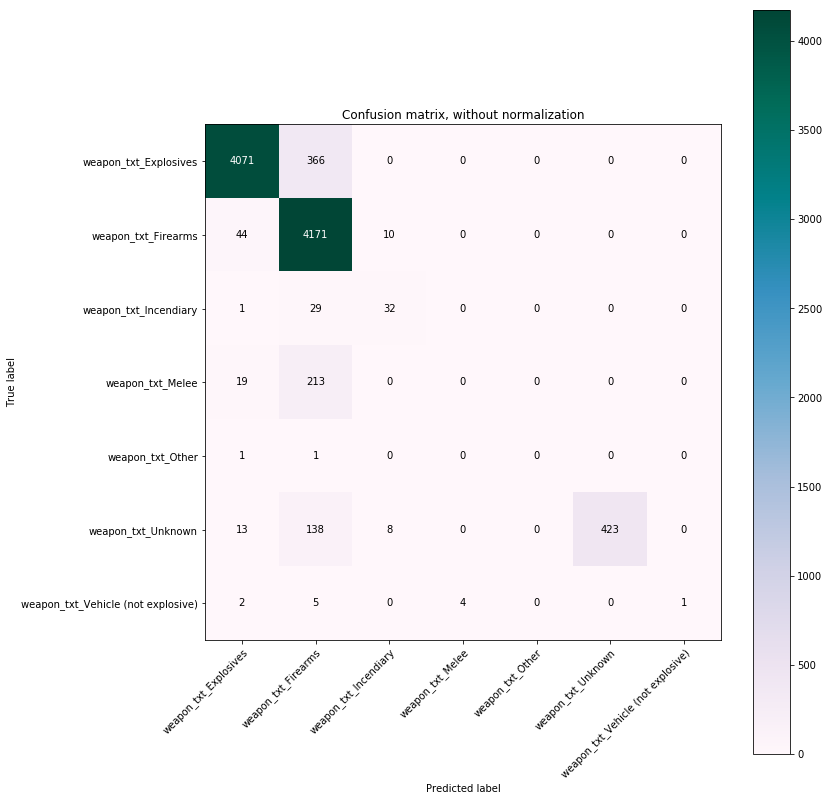

In [33]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.PuBuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

#### Roc Curve

In [34]:
# binarizar la variable y

from sklearn.preprocessing import label_binarize

y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [37]:
# Linear Regression

clsl = OneVsRestClassifier(linear_model.LinearRegression())
y_score = clsl.fit(X_train, y_train).predict(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))


In [38]:
# Roc Curve 
# Auc

from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [39]:
# micro-average Roc curve 
# micro-average Auc

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [40]:
# macro-average Roc curve 
# macro-average Auc

from scipy import interp

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

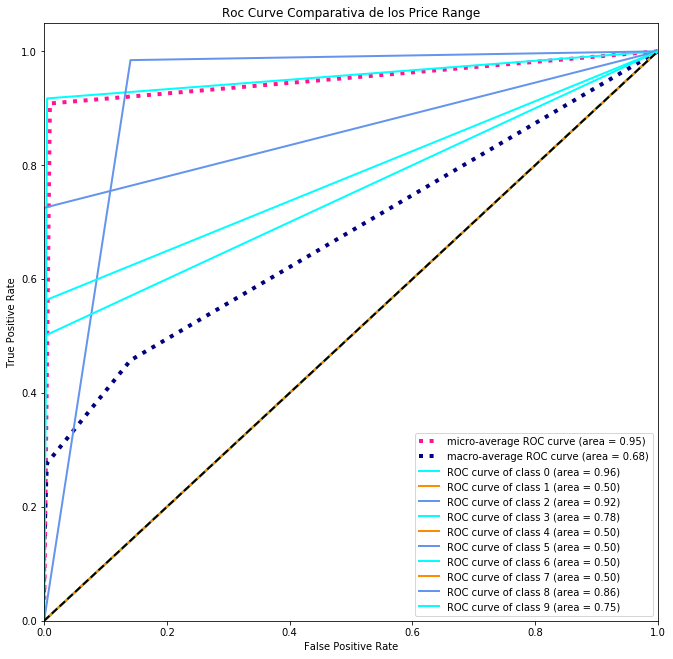

In [41]:
from itertools import cycle

plt.figure(figsize = (11, 11))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve Comparativa de los Price Range')
plt.legend(loc="lower right")
plt.show()

### Model SVC (probability = True)

#### y_pred Accuracy

In [10]:
# Prediction accuracy SVC

from sklearn import metrics
'''
clfc = OneVsRestClassifier(svm.SVC(probability = True))
clfc.fit(X_train, y_train)
y_pred2 = clfc.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
'''

clfc = OneVsRestClassifier(svm.SVC(probability = True))
y_score = clfc.fit(X_train, y_train).predict_proba(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

#### Precision vs Recall & F-score

In [11]:
actual_values = y_test.values.argmax(axis=1)
predictions = clfc.predict(X_test).argmax(axis=1)
predictions

array([2, 0, 2, ..., 2, 0, 2])

In [12]:
precision = pd.DataFrame(precision_score(actual_values, predictions, average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions, average=None))
f_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
precision_recall = pd.concat([precision, recall, f_score], axis=1)
precision_recall.columns = ['Precision', 'Recall', 'F score']
precision_recall.index = ['weapon_txt_Explosives', 'weapon_txt_Fake Weapons', 'weapon_txt_Firearms', 'weapon_txt_Incendiary', 'weapon_txt_Melee', 'weapon_txt_Radiological', 'weapon_txt_Vehicle (not explosive)', 'weapon_txt_Sabotage Equipment']
precision_recall.index.name = 'Weapon'
precision_recall

,Precision,Recall,F score
Weapon,,,
weapon_txt_Explosives,0.965370,0.927953,0.946292
weapon_txt_Fake Weapons,0.838220,0.978056,0.902755
weapon_txt_Firearms,0.666667,0.030769,0.058824
weapon_txt_Incendiary,0.666667,0.076271,0.136882
weapon_txt_Melee,0.000000,0.000000,0.000000
weapon_txt_Radiological,0.000000,0.000000,0.000000
weapon_txt_Vehicle (not explosive),0.997230,0.592105,0.743034
weapon_txt_Sabotage Equipment,0.000000,0.000000,0.000000


#### Accuracy Score (Balanced and not balanced)

In [16]:
# NO PONDERADO
# Ratio correct vs incorrect predictions

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.8998115577889447

In [17]:
# PONDERADO ---> Más real
# Ratio correct vs incorrect predictions

balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.32564424292397953

#### Confusion Matrix

Confusion matrix, without normalization
[[4070  315    1    0    0    0    0    0]
 [  90 4145    0    2    0    0    1    0]
 [   5   57    2    1    0    0    0    0]
 [  13  205    0   18    0    0    0    0]
 [   0    6    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0]
 [  35  213    0    0    0    0  360    0]
 [   3    3    0    6    0    0    0    0]]


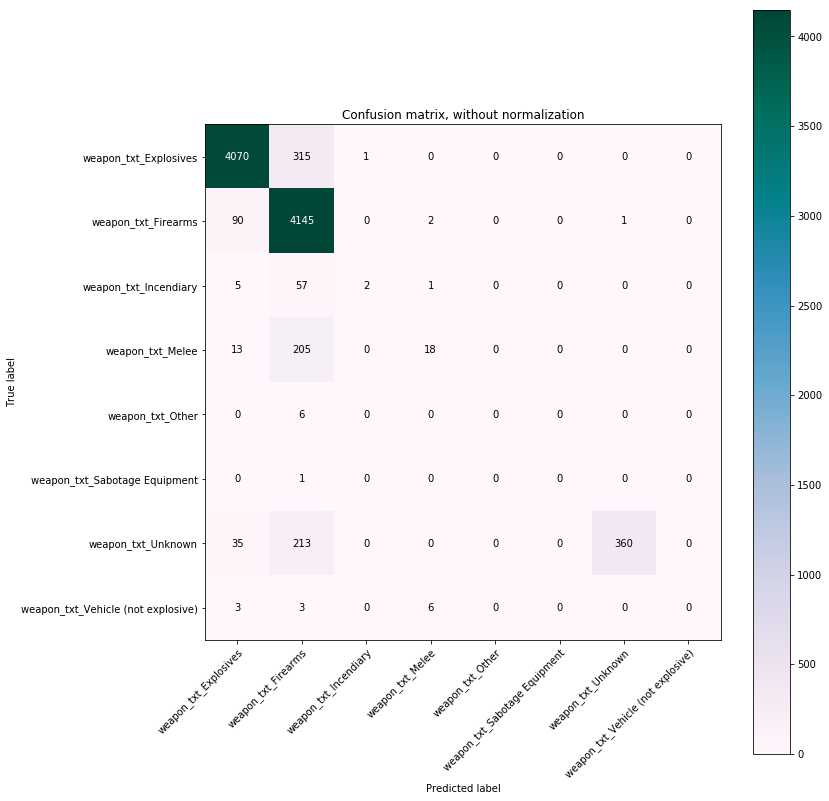

In [18]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.PuBuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

#### Roc Curve

In [19]:
# binarizar la variable y

from sklearn.preprocessing import label_binarize

y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [21]:
# SVC (Probability = True)

clfc = OneVsRestClassifier(svm.SVC(probability = True))
y_score = clfc.fit(X_train, y_train).predict_proba(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [22]:
# Roc Curve 
# Auc

from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [23]:
# micro-average Roc curve 
# micro-average Auc

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [24]:
# macro-average Roc curve 
# macro-average Auc

from scipy import interp

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

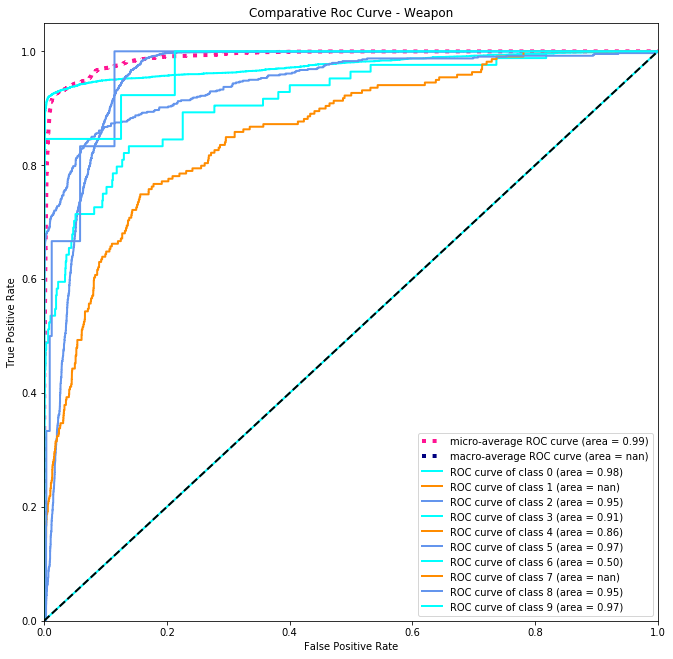

In [26]:
from itertools import cycle

plt.figure(figsize = (11, 11))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative Roc Curve - Weapon')
plt.legend(loc="lower right")
plt.show()

Explicación

### 3-. Predict if the attack is going to be extended more than 24h

In [45]:
y = gts[['more_than_24h']].copy()
X = gts.drop(['more_than_24h'], axis = 1)

display(X.head(), X.shape, y.head(), y.shape)

,iyear,npeople_attacking,suicide,nkill,country_txt_Algeria,country_txt_Bangladesh,country_txt_Cameroon,country_txt_Colombia,country_txt_Democratic Republic of the Congo,country_txt_Egypt,...,weapon_txt_Explosives,weapon_txt_Fake Weapons,weapon_txt_Firearms,weapon_txt_Incendiary,weapon_txt_Melee,weapon_txt_Other,weapon_txt_Radiological,weapon_txt_Sabotage Equipment,weapon_txt_Unknown,weapon_txt_Vehicle (not explosive)
0,1970,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1970,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1970,3,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1970,1,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1970,2,0,2,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


(47759, 103)

,more_than_24h
0,0
1,0
2,0
3,0
4,0


(47759, 1)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) # no se pone random_state para que sea randomly generated sin saltos
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(38207, 103) (9552, 103) (38207, 1) (9552, 1)


#### SVC

In [29]:
clfsvc = svm.SVC()
scores1 = cross_val_score(clfsvc, X, y, cv=5)
print(scores1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better 

[0.96670854 0.9714196  0.96430067 0.96000838 0.9609465 ]
Accuracy: 0.96 (+/- 0.01)


#### Random Forest Classifier

In [30]:
clsrf = RandomForestClassifier(n_estimators=20)
scores2 = cross_val_score(clsrf, X, y, cv=5)
print(scores2)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

[0.96555695 0.96199749 0.97644472 0.96733668 0.96471574]
Accuracy: 0.97 (+/- 0.01)


#### KNeighborsClassifier

In [32]:
from sklearn.neighbors import KNeighborsClassifier

clskn = KNeighborsClassifier(n_neighbors=3)
scores3 = cross_val_score(clskn, X, y, cv=5)
print(scores3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when

[0.96126466 0.93791876 0.96157873 0.95519263 0.95728196]
Accuracy: 0.95 (+/- 0.02)


#### LinearRegression

In [33]:
clslr = linear_model.LinearRegression()
scores4 = cross_val_score(clslr, X, y, cv=5)
print(scores4)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))

[-0.00281437  0.42663867  0.55499458  0.45513036  0.34981936]
Accuracy: 0.36 (+/- 0.38)


#### Logistic Regression (solver="lbfgs")

In [34]:
clslrg = LogisticRegression(solver="lbfgs")
scores5 = cross_val_score(clslrg, X, y, cv=5)
print(scores5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores5.mean(), scores5.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConver

[0.96545226 0.97215243 0.97895729 0.96723199 0.96607685]
Accuracy: 0.97 (+/- 0.01)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Fit Train & Test with SVC, Random Forest Classifier, KNN, Linear Regression & Logistic Regression

In [35]:
# SVC

clfsvc.fit(X_train, y_train)
clfsvc.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9681742043551089

In [36]:
# Random Forest Classifier

clsrf.fit(X_train, y_train)
clsrf.score(X_test, y_test)

/Users/Livia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.9716289782244556

In [37]:
# KNeighborsClassifier

clskn.fit(X_train, y_train)
clskn.score(X_test, y_test)

/Users/Livia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.9637772194304858

In [38]:
# Linear Regression

clslr.fit(X_train, y_train)
clslr.score(X_test, y_test)

0.3834375400959973

In [39]:
# Logistic Regression (solver="lbfgs")

clslrg.fit(X_train, y_train)
clslrg.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9703726968174204

### Model Random Forest Classifier

#### y_pred Accuracy

In [43]:
y_pred = clsrf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9708961474036851


#### Roc Curve

/Users/Livia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/Livia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


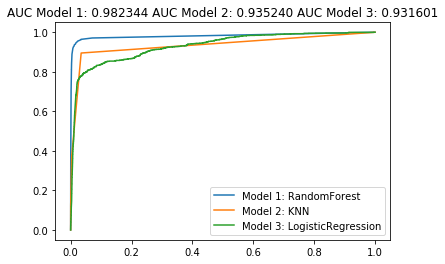

In [50]:
from sklearn import metrics

def plotMetricsCompare(X, y, clsrf, clskn, clslrg):
    clsrf.fit(X_train, y_train)
    clskn.fit(X_train, y_train)
    clslrg.fit(X_train, y_train)
    
    y_pred_proba1 = clsrf.predict_proba(X)[::,1]
    fpr1, tpr1, _ = metrics.roc_curve(y,  y_pred_proba1)
    auc1 = metrics.roc_auc_score(y, y_pred_proba1)
    
    y_pred_proba2 = clskn.predict_proba(X)[::,1]
    fpr2, tpr2, _ = metrics.roc_curve(y,  y_pred_proba2)
    auc2 = metrics.roc_auc_score(y, y_pred_proba2)
    
    y_pred_proba3 = clslrg.predict_proba(X)[::,1]
    fpr3, tpr3, _ = metrics.roc_curve(y,  y_pred_proba3)
    auc3 = metrics.roc_auc_score(y, y_pred_proba3)
    

    plt.title("AUC Model 1: {:2f} AUC Model 2: {:2f} AUC Model 3: {:2f}".format(auc1, auc2, auc3))
    plt.plot(fpr1,tpr1)
    plt.plot(fpr2,tpr2)
    plt.plot(fpr3,tpr3)

    plt.legend(["Model 1: RandomForest", "Model 2: KNN", "Model 3: LogisticRegression"])

plotMetricsCompare(X, y, clsrf, clskn, clslrg)